In [16]:
import os
import pandas as pd
from fastbook import *
from fastai.tabular.all import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from dtreeviz.trees import *
import sklearn

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)
     
traindf = pd.read_csv('/mnt/c/Users/jsult/Desktop/spacetitanic3/train.csv',low_memory=False)
testdf = pd.read_csv('/mnt/c/Users/jsult/Desktop/spacetitanic3/test.csv',low_memory=False)

traindf.dropna(inplace = True)


In [2]:
traindf.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [3]:
traindf.HomePlanet

0       Europa
1        Earth
2       Europa
3       Europa
4        Earth
         ...  
8688    Europa
8689     Earth
8690     Earth
8691    Europa
8692    Europa
Name: HomePlanet, Length: 6606, dtype: object

In [4]:
keep = ['CryoSleep',
 'VRDeck',
 'Spa',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Cabin',
 'HomePlanet','Transported']
traindf = traindf[keep].copy()

In [114]:
keep.remove('Transported')
testdf = testdf[keep].copy()

In [17]:
def split_group_number(df):
    df['Group'] = df['PassengerId'].apply(lambda x: x.split("_")[0] if pd.notna(x) else pd.NA)
    df['GroupNumber'] = df['PassengerId'].apply(lambda x: x.split("_")[1] if pd.notna(x) else pd.NA)
    return df
traindf = split_group_number(traindf)
testdf = split_group_number(testdf)

In [18]:
def split_names(df):
    # Create new columns for first name and last name
    df['FirstName'] = df['Name'].apply(lambda x: x.split()[0] if pd.notna(x) else pd.NA)
    df['LastName'] = df['Name'].apply(lambda x: x.split()[1] if pd.notna(x) else pd.NA)
    df.drop(columns = ['Name'],inplace = True)
    return df
traindf = split_names(traindf)
testdf = split_names(testdf)

In [134]:
def split_cabin(df):
    df['CabinDeck'] = df['Cabin'].apply(lambda x: x.split("/" )[0] if pd.notna(x) else pd.NA)
    df['CabinSide'] = df['Cabin'].apply(lambda x: x.split("/")[2] if pd.notna(x) else pd.NA)
    df['CabinNum'] = df['Cabin'].apply(lambda x: int(x.split("/")[1]) if pd.notna(x) else pd.NA)

    df.drop(columns = ['Cabin'],inplace = True)
    return df
traindf = split_cabin(traindf)
testdf= split_cabin(testdf)

In [152]:
traindf[traindf.CabinDeck == 'A'].Transported.value_counts()

Transported
False    106
True     101
Name: count, dtype: int64

CabinDeck
F    2152
G    1973
E     683
B     628
C     587
D     374
A     207
T       2
Name: count, dtype: int64

In [135]:
traindf.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'Group', 'GroupNumber', 'FirstName', 'LastName',
       'CabinDeck', 'CabinSide', 'CabinNum'],
      dtype='object')

In [119]:
traindf.CabinNum

0          0
1          0
2          0
3          0
4          1
        ... 
8688      98
8689    1499
8690    1500
8691     608
8692     608
Name: CabinNum, Length: 6606, dtype: int64

In [120]:

deck = 'A','B','C','D','E','F','G','T'
     

traindf['CabinDeck'] = traindf['CabinDeck'].astype('category')
traindf['CabinDeck'].cat.set_categories(new_categories=deck,ordered = True)

0       B
1       F
2       A
3       A
4       F
       ..
8688    A
8689    G
8690    G
8691    E
8692    E
Name: CabinDeck, Length: 6606, dtype: category
Categories (8, object): ['A' < 'B' < 'C' < 'D' < 'E' < 'F' < 'G' < 'T']

In [111]:
cabinstr = list(traindf['CabinNum'].unique())
cabinnum = []
for item in cabinstr:
    cabinnum.append(int(item))
cabinnum



[0,
 1,
 2,
 3,
 4,
 5,
 6,
 8,
 9,
 10,
 11,
 7,
 12,
 13,
 15,
 14,
 17,
 18,
 16,
 20,
 19,
 23,
 21,
 27,
 29,
 31,
 25,
 26,
 22,
 28,
 35,
 30,
 24,
 38,
 36,
 41,
 42,
 33,
 34,
 32,
 44,
 45,
 46,
 40,
 47,
 37,
 48,
 43,
 52,
 53,
 54,
 49,
 50,
 56,
 51,
 59,
 61,
 63,
 64,
 65,
 55,
 67,
 60,
 68,
 72,
 73,
 62,
 74,
 57,
 76,
 78,
 66,
 82,
 83,
 84,
 69,
 90,
 71,
 91,
 92,
 96,
 75,
 97,
 77,
 79,
 98,
 80,
 81,
 85,
 100,
 101,
 87,
 103,
 70,
 88,
 89,
 93,
 110,
 95,
 111,
 99,
 102,
 114,
 115,
 116,
 105,
 86,
 108,
 118,
 109,
 120,
 121,
 124,
 125,
 126,
 94,
 131,
 133,
 112,
 113,
 135,
 136,
 138,
 39,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 122,
 123,
 107,
 147,
 127,
 149,
 132,
 134,
 153,
 154,
 156,
 117,
 161,
 163,
 165,
 148,
 151,
 152,
 169,
 119,
 158,
 159,
 170,
 171,
 173,
 160,
 175,
 176,
 129,
 130,
 164,
 166,
 187,
 167,
 188,
 137,
 190,
 139,
 191,
 192,
 194,
 172,
 195,
 196,
 198,
 201,
 178,
 179,
 202,
 150,
 182,
 204,
 183,
 184,

/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/pyth

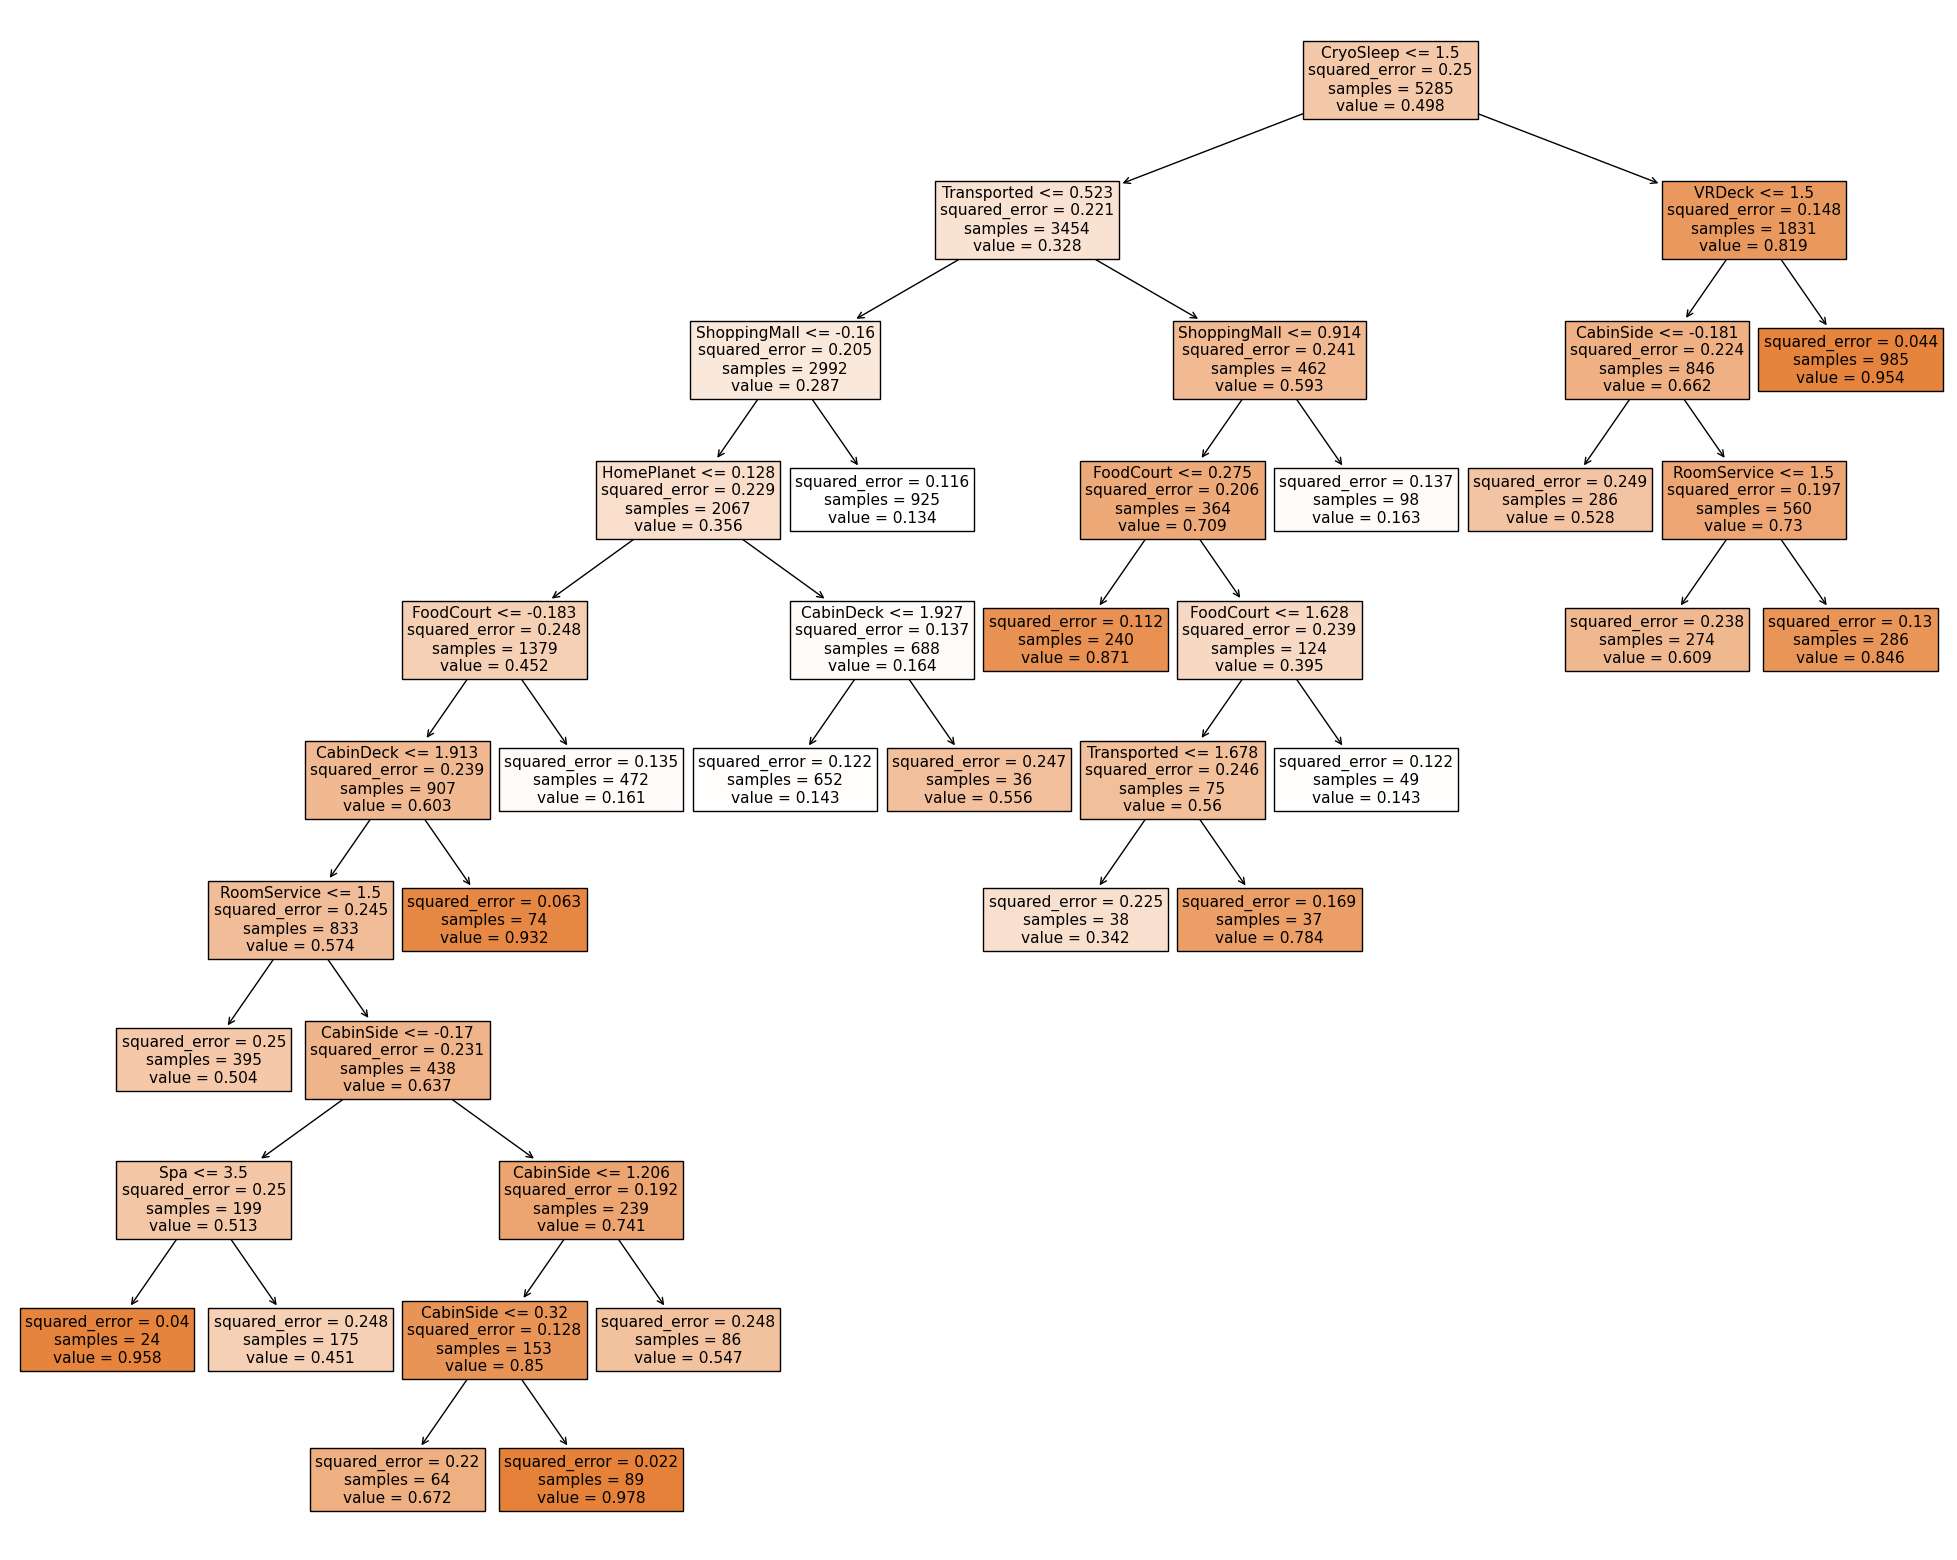

In [121]:
splits = RandomSplitter(seed = 1)(range_of(traindf))
dep_var = 'Transported'
procs = [Categorify,FillMissing,Normalize]
cont,cat = cont_cat_split(traindf, 1, dep_var=dep_var)
to = TabularPandas(traindf, procs, cat, cont, y_names=dep_var,splits = splits)



xs,y = to.train.xs,to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

m = DecisionTreeRegressor(max_leaf_nodes=20)
m.fit(xs, y)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(m,
                   feature_names= traindf.columns,
                   filled=True)

In [122]:
((m.predict(valid_xs) > 0.5) == valid_y).sum() / len(valid_y)


0.7956093868281605

In [32]:
def attempt(xs,y,valid_xs,valid_y):
    def run():
        m = RandomForestClassifier(n_estimators= 100, max_leaf_nodes= 50)
        m.fit(xs, y)
        preds = m.predict(valid_xs)
        return (mean_absolute_error(valid_y, preds)), (preds == valid_y).sum() /len(valid_y)

    rmses = []
    preds = []

    for i in range(5):
        a,b = run()
        rmses.append(a)
        preds.append(b)
    print("rmse",np.mean(rmses))
    print("preds", np.mean(preds))

attempt(xs,y,valid_xs,valid_y)

rmse 0.1990915972747918
preds 0.8009084027252081


In [61]:
attempt(xs,y,valid_xs,valid_y)

rmse 0.19560938682816048
preds 0.8043906131718395


In [67]:
attempt(xs,y,valid_xs,valid_y)

rmse 0.19576078728236185
preds 0.8042392127176383


In [82]:
attempt(xs,y,valid_xs,valid_y)

rmse 0.19273277819833462
preds 0.8072672218016654


In [126]:
attempt(xs,y,valid_xs,valid_y)

rmse 0.19379258137774413
preds 0.8062074186222559


In [127]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)
fi[:30]

,cols,imp
0,CryoSleep,0.481826
4,VRDeck,0.140890
5,Spa,0.091020
7,FoodCourt,0.068573
1,HomePlanet,0.065002
6,RoomService,0.063403
9,CabinNum,0.036654
8,ShoppingMall,0.024321
3,CabinSide,0.019251
2,CabinDeck,0.009061


In [94]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)
fi[:30]

,cols,imp
0,CryoSleep,0.488181
5,VRDeck,0.142748
6,Spa,0.092220
8,FoodCourt,0.069478
7,RoomService,0.069087
1,HomePlanet,0.065859
4,CabinNum,0.034927
9,ShoppingMall,0.024642
2,CabinDeck,0.006621
3,CabinSide,0.006237


In [7]:
cont,cat = cont_cat_split(testdf, 1, dep_var=dep_var)
mode_values = testdf[cat].mode().iloc[0]
testdf[cat] = testdf[cat].fillna(mode_values)


for column in cont:
    mode_value = testdf[column].median()  # Calculate the mode for the column
    testdf[column].fillna(mode_value, inplace=True)  # Fill missing values with mode
    


In [8]:
to_new = to.train.new(testdf)
to_new.process()


/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3

In [9]:


testtran = [True if x == 1 else False for x in list(m.predict(to_new.xs))]
testdf['Transported'] = testtran
ret = testdf[['PassengerId','Transported']]

ret.to_csv('submit.csv',index=False)